<h1>Benchmarking Darcy flow using manufactured solutions</h1>
<p>
    This notebook demonstrates how one can solve Darcy's flow using the mixed Poisson formulation. It also shows the idea of utilizing class inheritance to expand the existing code structure. This benchmark problem is based on Ada Johanne Ellingsrud's masters thesis: Preconditioning unified mixed discretization of coupled Darcy-Stokes flow. <a href="https://www.duo.uio.no/bitstream/handle/10852/45338/paper.pdf" target="_blank">[link]</a>
</p>

In [1]:
from dolfin import Constant, Expression, plot, inner, interpolate, assemble, Function, norm
from dolfin.common.plotting import mplot_function

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.insert(0, '../../')
from reaktoro_transport.problem import DarcyFlowAngot
#from reaktoro_transport.tests import darcyflow_benchmark
from reaktoro_transport.mesh import MarkedRectangleMesh

%matplotlib inline
plt.rcParams.update({'font.size': 16})

In [2]:
mesh_factory = MarkedRectangleMesh()

In [3]:
mesh_factory.set_bottom_left_coordinates(coord_x = -1.0, coord_y = -1.0)
mesh_factory.set_top_right_coordinates(coord_x = 1.0, coord_y = 1.0)
mesh_factory.set_number_of_elements(16, 16)
mesh_factory.set_mesh_type('triangle')
mesh = mesh_factory.generate_mesh()
boundary_markers, marker_dict = mesh_factory.generate_boundary_markers()
domain_markers = mesh_factory.generate_domain_markers()

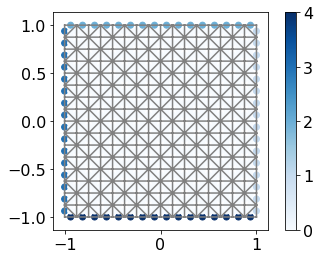

In [4]:
fig, ax = plt.subplots(1,1)
plot(mesh)
cb = mesh_factory.plot_boundary_markers(ax)
fig.colorbar(cb)
plt.show()

In [5]:
class DarcyFlowBenchmarkProblem(DarcyFlowAngot):
    def add_source_term(self):
        momentum_sources = [self._mu/self._k*Expression(('sin(M_PI*x[1])', 'cos(M_PI*x[0])'), degree=1),
                            Expression(('M_PI*cos(M_PI*x[0])*exp(x[1])',
                                        'sin(M_PI*x[0])*exp(x[1])'), degree=1)]

        self.add_momentum_source(momentum_sources)
        self.add_momentum_source_to_residual_form(momentum_sources)
    
    def get_solution(self):
        self.sol_pressure = interpolate(Expression('exp(x[1])*sin(M_PI*x[0])', degree=1), self.pressure_func_space)
        self.sol_velocity = interpolate(Expression(('sin(M_PI*x[1])', 'cos(M_PI*x[0])'), degree=1),
                                   self.velocity_func_space)
        
        return self.sol_pressure, self.sol_velocity
    
    def get_error_norm(self):
        pressure_error = Function(self.pressure_func_space)
        velocity_error = Function(self.velocity_func_space)
        
        pressure_error.assign(self.fluid_pressure-self.sol_pressure)
        velocity_error.assign(self.fluid_velocity-self.sol_velocity)
        
        pressure_error_norm = norm(pressure_error, 'l2')
        velocity_error_norm = norm(velocity_error, 'l2')
        
        return pressure_error_norm, velocity_error_norm
        
problem = DarcyFlowBenchmarkProblem(mesh, boundary_markers, domain_markers)

In [6]:
problem.mark_flow_boundary(pressure = [marker_dict['left'], marker_dict['right']],
                           velocity = [marker_dict['top'], marker_dict['bottom']])

problem.set_pressure_fe_space('DG', 0)
problem.set_velocity_fe_space('RT', 1)

problem.set_permeability(Constant(1.0))
problem.set_porosity(Constant(1.0))
problem.set_fluid_density(1.0)
problem.set_fluid_viscosity(1.0)
problem.set_gravity((0.0, 0.0))

problem.set_pressure_bc([Constant(0.0), Constant(0.0)])
problem.generate_form()
problem.generate_residual_form()
problem.set_velocity_bc([Expression(('sin(M_PI*x[1])', 'cos(M_PI*x[0])'), degree=1)]*2)

problem.set_solver()
problem.set_angot_parameters(r_val = 1e4)

In [7]:
problem.add_source_term()
problem.assemble_matrix()

In [8]:
%%time

problem.solve_flow()

CPU times: user 22.7 ms, sys: 5.29 ms, total: 28 ms
Wall time: 27.4 ms


In [9]:
problem.get_residual()

1.656339685950783e-05

In [10]:
velocity = problem.get_fluid_velocity()
pressure = problem.get_fluid_pressure()

solution_p, solution_v = problem.get_solution()

print(problem.get_error_norm())

(0.029460698063084188, 0.09513613006378717)


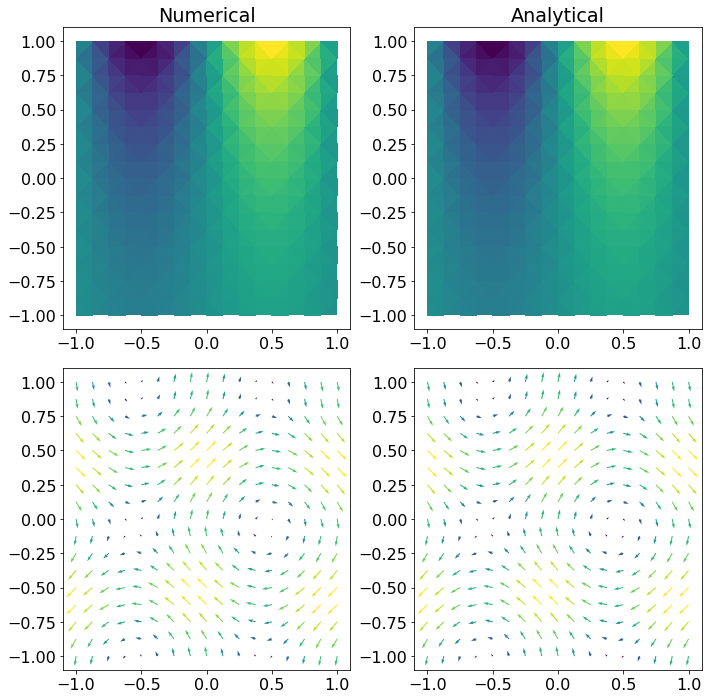

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))

mplot_function(ax[0,0], pressure)
mplot_function(ax[1,0], velocity)

mplot_function(ax[0,1], solution_p)
mplot_function(ax[1,1], solution_v)

ax[0,0].set_title('Numerical')
ax[0,1].set_title('Analytical')

plt.tight_layout()
plt.show()